# Sub models - Contact stiffness example
In this note book we will look at how to add a sub model to a simulation, here we will look at the contact stiffness sub model and use it to numerically recreate a famous solution from contact mechanics. Namely, that for the indentation of a cylindrical indeter into an elastic half space the contact stiffness is the diameter of the cylinder multiplied by the reduced modulus.

First lets define our geometry

In [1]:
%matplotlib inline
import numpy as np
import slippy.surface as s
import slippy.contact as c

# Geometry
The first step in making a contact model is defining the geometry of the surfaces which come into contact. Slippy dosn't provide a cylindrical indenter so we will make our own using numpy. We could also define this analyitcally if we wanted to use it a lot or combine it with other surface shapes.

In [2]:
diameter = 1
resolution = 512
X, Y = np.meshgrid(np.linspace(-diameter, diameter, resolution), 
                   np.linspace(-diameter, diameter, resolution))
indenter_profile = np.array((X**2+Y**2)<(diameter/2)**2, dtype=np.float32)
grid_spacing = X[1,1]-X[0,0]
indenter = s.Surface(profile=indenter_profile, grid_spacing=grid_spacing)
half_space = s.FlatSurface(shape=(resolution, resolution), grid_spacing=grid_spacing, 
                           generate=True)

# Materials
Now let's define the materials for each of the surfaces. Here we will use an elastic half space and a rigid indenter.

In [3]:
indenter.material = c.rigid
E, v = 200e9, 0.3
half_space.material = c.Elastic('steel', {'E':E, 'v':v})
reduced_modulus = 1/((1-v**2)/E)

# Making a contact model
To coordinate the solution we need a contact model. Note that the first surface is the deformable surface.

In [4]:
my_model = c.ContactModel('Contact_stiffness_example', half_space, indenter)

# Making a step and adding a sub model
We need to add a main step which will solve the normal contact problem, then we can add our sub model to this step.

IMPORTANT: You must add the step to the contact model only when all the sub models have been added to the step.

In [5]:
step = c.StaticStep('loading', interference = 1e-4, periodic_geometry=True)
sub_model = c.sub_models.ResultContactStiffness('stiffness', definition='far points', 
                                                loading=False)
step.add_sub_model(sub_model)
my_model.add_step(step)

# Solving the model
Solving the model is very simple$^*$:

$^*$unless you get errors...

In [6]:
results = my_model.solve()

# Comparing the analytical and numerical results
By default the contact stiffness sub model gives results in Force per unit of modeled area per unit displacement. So to convert to the total force we simply need to multiply by the total modelled area:

In [7]:
numerical_stiffness = results['s_contact_stiffness_unloading_fp_z_0']*(2*diameter)**2
analytical_stiffness = reduced_modulus*diameter
print(f"Numerical stiffness is: {numerical_stiffness:.4}")
print(f"Analytical stiffness is: {analytical_stiffness:.4}")
print(f"Error: {abs(numerical_stiffness-analytical_stiffness)/analytical_stiffness*100:.2}%")

Numerical stiffness is: 2.246e+11
Analytical stiffness is: 2.198e+11
Error: 2.2%


# Showing other results
As always we can also show other results that were found along the way, for eample the displacement of the surface caused by the indenter.

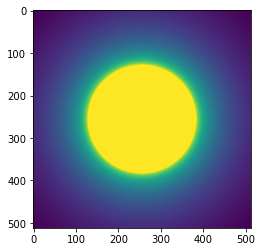

In [8]:
import matplotlib.pyplot as plt
plt.imshow(results['total_displacement_z'])